In [1]:
#!/usr/bin/python

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import scipy.io

# import os
# import sys
import numpy as np

import time

from reservoir import Reservoir
import data1D
import data_utils

%load_ext autoreload
%autoreload 2
%aimport data1D
%aimport reservoir

%matplotlib inline
import matplotlib.pyplot as plt

# setx PATH "%PATH%;C:\Octave\Octave-5.1.0.0

In [83]:
# Input data
n_sequence=1
spatial_points = 30
lyap_exp = 0.0461
n_train = 5000
n_test = 2000
refreshing = True
ks_data_origin, xx, tt = data1D.kuramoto_sivashinsky_matlab(sequence_length=n_train+n_test, n_sequence=n_sequence, spatial_points=spatial_points)
# ks_data_origin=ks_data_origin+np.random.rand(ks_data_origin.shape[0],ks_data_origin.shape[1],ks_data_origin.shape[2])
ks_data_train = ks_data_origin[:, :n_train, :]
input_shape=ks_data_train.shape

In [88]:
b = Reservoir(n_res=2000, res_scale=.1, res_encoding='phase', res_enc_param=np.pi,
              input_scale=.7, input_encoding='phase',
              random_projection='simulation', weights_type='complex gaussian',
              activation_fun='intensity', activation_param=10,
              parallel_runs=1,  bias_scale=0.1, leak_rate=.8,
              pred_horizon=1, rec_pred_steps=1, forget = 100,
              train_method='ridge', train_param=1e2, verbose=1, 
              refreshing=refreshing
             )

# Algorithm training
b.fit(ks_data_train);

Predict horizon has been set to 1
Reservoir Computing algorithm - Training phase:

Initialization complete. 		Elapsed time: 0.26329708099365234 s
100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:22<00:00, 222.83it/s]
Reservoir iterations complete. 		Elapsed time: 22.502873182296753 s
Training complete. 			Elapsed time: 0.3560492992401123 s
Training score: 0.9997554465775976


In [89]:
# testing data
# ks_data, _, _ = data1D.kuramoto_sivashinsky_matlab(sequence_length=1000, n_sequence=1, spatial_points=spatial_points)
ks_data_test = ks_data_origin[:, n_train:n_train+n_test, :]
# Algorithm testing
if refreshing:
    pred_output, rmse_vec = b.predict_and_score(ks_data_test, detailed_score=True, n_test=n_test)
else:
    pred_output, rmse, rmse_vec = b.predict_and_score(ks_data_test, detailed_score=True)
# print(pred_output.shape)
# print(rmse.shape)
# print(rmse_vec[:3])

Reservoir Computing algorithm - Testing phase:

Initialization complete. 		Elapsed time: 0.000997304916381836 s
100%|███████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 231.74it/s]
Reservoir iterations complete. 		Elapsed time: 0.43982410430908203 s
Testing complete. 			Elapsed time: 8.455398797988892 s
Testing score: 0.0011983718503088834


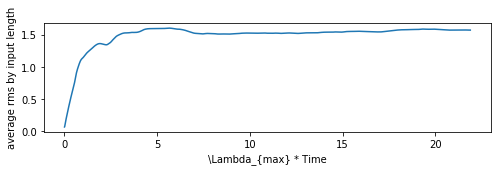

In [90]:
if refreshing:
    total_pred = (n_test-b.forget)*b.rec_pred_steps
    length_input = pred_output.shape[0] - total_pred
else:
    total_pred = b.pred_horizon*b.rec_pred_steps
    length_input = pred_output.shape[0] - total_pred
time_input = range(length_input)
time_pred = tt[0:total_pred]*lyap_exp

if refreshing:
    plt.figure(1,figsize=(8,2))
    plt.ylabel('average rms by input length')
    plt.xlabel('\Lambda_{max} * Time')
    plt.plot(time_pred[:], rmse_vec[:])
    # scipy.io.savemat('time_pred_new_2.mat', dict(time_pred_new_2=time_pred))
    # scipy.io.savemat('rmse_vec_new_2.mat', dict(rmse_vec_new_2=rmse_vec))
    plt.show;
else:
    plt.figure(1,figsize=(8,2))
    plt.ylabel('average rms by input length')
    plt.xlabel('\Lambda_{max} * Time')
    plt.plot(time_pred[1:], rmse_vec[1:])
    # scipy.io.savemat('time_pred_new_2.mat', dict(time_pred_new_2=time_pred))
    # scipy.io.savemat('rmse_vec_new_2.mat', dict(rmse_vec_new_2=rmse_vec))
    plt.show;

    plt.figure(2,figsize=(10,2))
    plt.title('rmse for phase encoding')
    plt.ylabel('input length')
    plt.xlabel('\Lambda_{max} * Time')
    im=plt.pcolormesh(time_pred[1:], time_input[:], rmse[:,1:], cmap='gist_heat')
    plt.colorbar(im)
    plt.show;

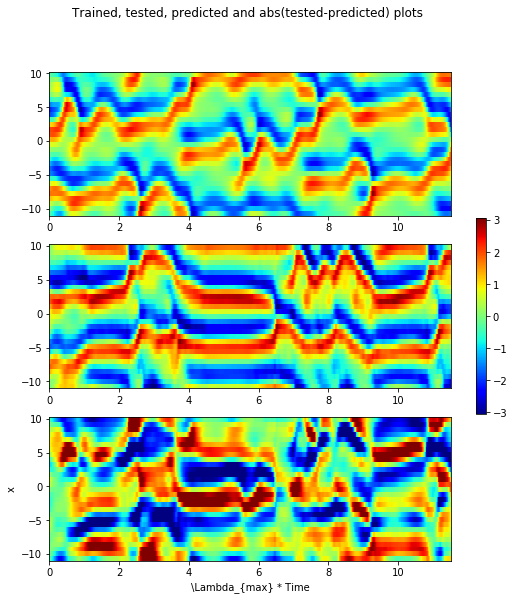

In [91]:
if refreshing:
    n_input = 10
    # i=0
    # time = (tt[0:n_input] if i==0 else tt[0:total_pred])*lyap_exp
    # total_pred = b.pred_horizon*b.rec_pred_steps
    total_pred = 1000
    # print(total_pred)

    # n_input = 500 #round(pred_output.shape[0]/2-300)

    input_data = ks_data_test[0, :n_input+b.forget, :]

    prediction = pred_output[:total_pred, :]

    targetted_data = ks_data_test[0, n_input+b.forget:n_input+b.forget+total_pred, :]

    vmax = max(abs(np.concatenate((targetted_data,input_data)).flatten()))
    vmin = -vmax

    # plot training data
    fig, axs = plt.subplots(3, 1, sharex=False, figsize=(9,9))
    plt.suptitle('Trained, tested, predicted and abs(tested-predicted) plots                       ')
    plt.ylabel('x')
    plt.xlabel('\Lambda_{max} * Time')
    # print(targetted_data.shape)
    # print(prediction.shape)
    # datum = [input_data, targetted_data, prediction, np.abs(targetted_data-prediction)]
    datum = [targetted_data, prediction, targetted_data-prediction]
    # print(datum[0].shape)
    # time = (tt[0:n_input+b.forget] if i==0 else tt[0:total_pred])*lyap_exp
    # xx_axs, time_axs = np.mgrid[xx, time]
    xx_axs = np.zeros((spatial_points, total_pred))
    time_axs = np.zeros((spatial_points, total_pred))
    for i in range(total_pred):
        xx_axs[:, i] = xx
    for i in range(spatial_points):
        time_axs[i, :] = (tt[n_input+b.forget:n_input+b.forget+total_pred]-tt[n_input+b.forget])*lyap_exp
    for i in range(3):
        # im=axs[i].pcolormesh(time, xx, datum[i].T, cmap='viridis', vmin=vmin, vmax=vmax)
        im=axs[i].pcolormesh(time_axs, xx_axs, datum[i].T, cmap=plt.get_cmap('jet'), vmin=vmin, vmax=vmax)
    fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.4)

    # plt.figure(3,figsize=(9,2.5))
    # im=plt.pcolormesh(time_axs, xx_axs, datum[2].T, cmap='gray')
    # plt.colorbar(im)
    # # plt.savefig('DND_input_data.png')

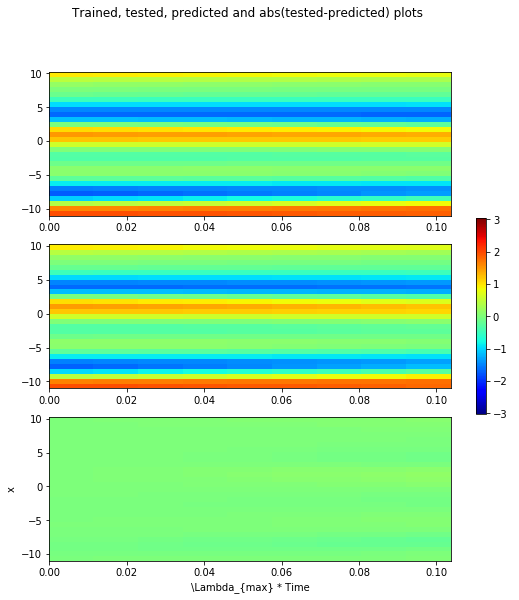

In [23]:
n_input = 10
# i=0
# time = (tt[0:n_input] if i==0 else tt[0:total_pred])*lyap_exp
# total_pred = b.pred_horizon*b.rec_pred_steps
total_pred = 10
# print(total_pred)

# n_input = 500 #round(pred_output.shape[0]/2-300)

input_data = ks_data_test[0, :n_input+b.forget, :]

prediction = pred_output[n_input, :total_pred*spatial_points].reshape(-1, spatial_points)

targetted_data = ks_data_test[0, n_input+b.forget:n_input+b.forget+total_pred, :]

vmax = max(abs(np.concatenate((targetted_data,input_data)).flatten()))
vmin = -vmax

# plot training data
fig, axs = plt.subplots(3, 1, sharex=False, figsize=(9,9))
plt.suptitle('Trained, tested, predicted and abs(tested-predicted) plots                       ')
plt.ylabel('x')
plt.xlabel('\Lambda_{max} * Time')
# print(targetted_data.shape)
# print(prediction.shape)
# datum = [input_data, targetted_data, prediction, np.abs(targetted_data-prediction)]
datum = [targetted_data, prediction, targetted_data-prediction]
# print(datum[0].shape)
# time = (tt[0:n_input+b.forget] if i==0 else tt[0:total_pred])*lyap_exp
# xx_axs, time_axs = np.mgrid[xx, time]
xx_axs = np.zeros((spatial_points, total_pred))
time_axs = np.zeros((spatial_points, total_pred))
for i in range(total_pred):
    xx_axs[:, i] = xx
for i in range(spatial_points):
    time_axs[i, :] = (tt[n_input+b.forget:n_input+b.forget+total_pred]-tt[n_input+b.forget])*lyap_exp
for i in range(3):
    # im=axs[i].pcolormesh(time, xx, datum[i].T, cmap='viridis', vmin=vmin, vmax=vmax)
    im=axs[i].pcolormesh(time_axs, xx_axs, datum[i].T, cmap=plt.get_cmap('jet'), vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.4)

# plt.figure(3,figsize=(9,2.5))
# im=plt.pcolormesh(time_axs, xx_axs, datum[2].T, cmap='gray')
# plt.colorbar(im)
# # plt.savefig('DND_input_data.png')

In [7]:
n_input = 1250 #round(pred_output.shape[0]/2-300)
prediction = np.zeros((total_pred, spatial_points + 1))
for i in range(total_pred):
    prediction[i, :] = pred_output[n_input, i*(spatial_points+1):(i+1)*(spatial_points + 1)]
all_data = np.concatenate((y_target[0:n_input, 0:spatial_points+1], prediction*(1/np.amax(prediction))))

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10,6))
data_1 = y_target[0:n_input+total_pred, 0:spatial_points+1].T
data_2 = all_data.T
data_3 = y_target[0:n_input+total_pred, 0:spatial_points+1].T-all_data.T
time = tt[0:n_input+total_pred]*lyap_exp
vmax = max(abs(np.concatenate((data_1,data_2,data_3)).flatten()))
vmin = -vmax
plt.title('Solution u(x,t) of Kuramoto-Sivashinsky equation, system size L = 22:')
plt.ylabel('x')
plt.xlabel('Time')
im=axs[0].pcolormesh(time, xx, y_target[0:n_input+total_pred, 0:spatial_points+1].T, cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=axs[0])

im=axs[1].pcolormesh(time, xx, all_data.T, cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=axs[1])

im=axs[2].pcolormesh(time, xx, np.abs(y_target[0:n_input+total_pred, 0:spatial_points+1].T-all_data.T), cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=axs[2])
plt.show

IndexError: index 1250 is out of bounds for axis 0 with size 900